# Demo example: 

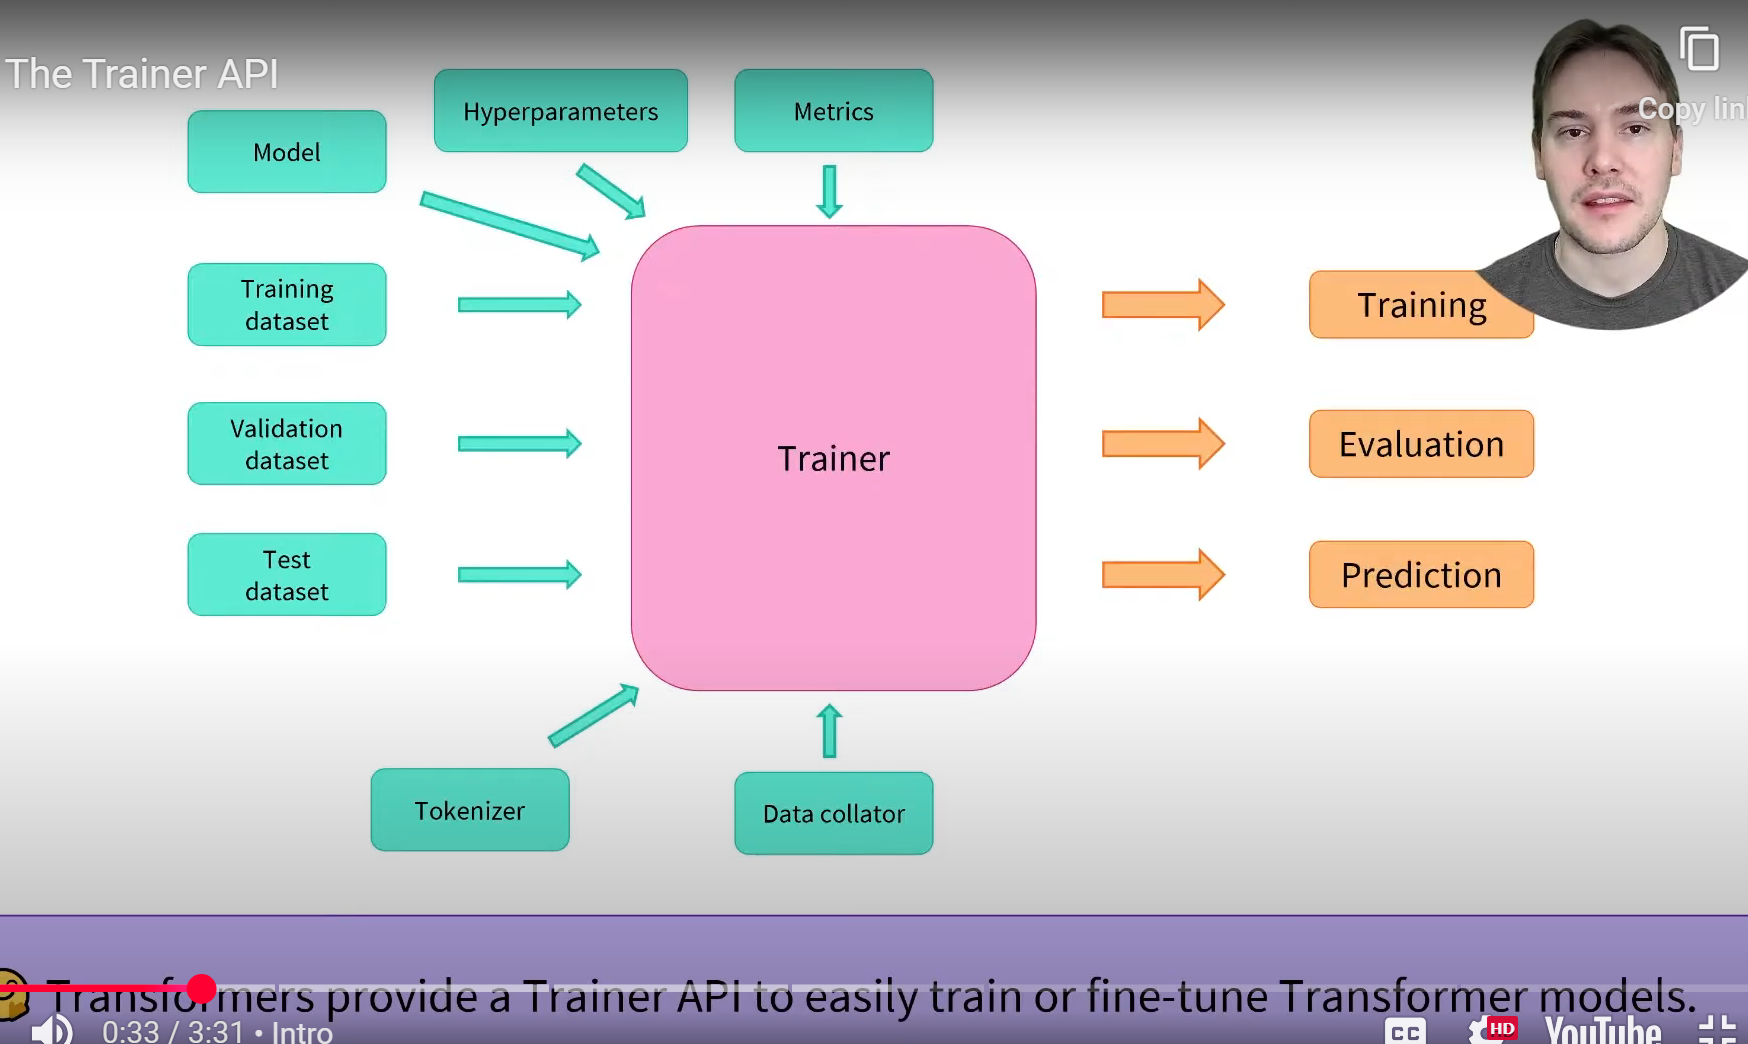

In [4]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
raw_datasets

In [ ]:
# lets get model







In [2]:
from transformers import TrainingArguments
training_args = TrainingArguments("test-trainer")

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

In [ ]:
predictions = trainer.predict(tokenized_datasets["validation"])
print(predictions.predictions.shape, predictions.label_ids.shape)

In [10]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)

In [ ]:
import evaluate

metric = evaluate.load("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

In [6]:
def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

# Detailed guide

https://huggingface.co/docs/transformers/en/trainer

# Exercise: Fine tune GPT2 for IMDB reviews classification

In [1]:
%reset -f

## Get the data

In [1]:
%reset -f

In [1]:
from datasets import load_dataset
dataset = load_dataset("stanfordnlp/imdb", split="train")
dataset = dataset.train_test_split(test_size=0.2)

In [2]:
## Get the GPT2 model + add classification head
from transformers import AutoModelForSequenceClassification, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('gpt2')   # Exercise: Repeat this for a different model. Find a suitable model.
model = AutoModelForSequenceClassification.from_pretrained('gpt2', num_labels=2)

tokenizer.pad_token = tokenizer.eos_token 
model.config.pad_token_id = tokenizer.pad_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [4]:
def tokenize_function(example):
    return tokenizer(example["text"], padding=True, truncation=True)

In [5]:
tokenized_dataset = dataset.map(tokenize_function)


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [6]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    "gpt2-imdb",
    per_device_train_batch_size=4,
    )

In [7]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    #data_collator=data_collator,
    tokenizer=tokenizer,
)

/tmp/ipykernel_1801/2101626295.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [10]:
predictions = trainer.predict(tokenized_dataset['test'])

In [11]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)

In [12]:
np.sum(preds == predictions.label_ids)/5000

0.5012

In [13]:
# approximately 50 % accuracy before trainnig
import evaluate
accuracy_metric = evaluate.load("accuracy")

In [14]:
results = accuracy_metric.compute(references=predictions.label_ids, predictions=preds)
print(results)

{'accuracy': 0.5012}


In [17]:
# Lets check accuracy with the trained model
checkpoint = "./test-trainer/checkpoint-7500"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)  
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

# tokenizer.pad_token = tokenizer.eos_token 
# model.config.pad_token_id = tokenizer.pad_token_id

In [19]:
def compute_metrics(eval_preds):
    metric = evaluate.load("accuracy")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [20]:
training_args = TrainingArguments(
    "test-trainer-testing", 
    evaluation_strategy="epoch")

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
#    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_1801/2949086353.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.285100,0.298687,0.924600
2,0.209200,0.318263,0.928800


In [ ]:
# Lets check accuracy with the trained model
checkpoint = "HuggingFaceNLP_Course/03_FineTuning/test-trainer/checkpoint-7500"

In [21]:
predictions = trainer.predict(tokenized_dataset['test'])

In [22]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)

In [23]:
np.sum(preds == predictions.label_ids)/5000

0.9764

In [24]:
import evaluate
accuracy_metric = evaluate.load("accuracy")

In [25]:
results = accuracy_metric.compute(references=predictions.label_ids, predictions=preds)
print(results)

{'accuracy': 0.9764}


In [ ]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

# Replace with your model checkpoint directory
checkpoint = "./test-trainer/checkpoint-7500"

# Load the model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Create a pipeline
nlp_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer)

Device set to use cuda:0


[{'label': 'LABEL_1', 'score': 0.997484564781189}]


In [28]:
# Test the pipeline
print(nlp_pipeline("This is a bad movie!"))

[{'label': 'LABEL_0', 'score': 0.9995388984680176}]


In [29]:
# Test the pipeline
print(nlp_pipeline("It actually pains me to say it, but this movie was horrible on every level. The blame does not lie entirely with Van Damme as you can see he tried his best, but let's face it, he's almost fifty, how much more can you ask of him? I find it so hard to believe that the same people who put together Undisputed 2; arguably the best (western) martial arts movie in years, created this. Everything from the plot, to the dialog, to the editing, to the overall acting was just horribly put together and in many cases outright boring and nonsensical. Scott Adkins who's fight scenes seemed more like a demo reel, was also terribly underused and not even the main villain which is such a shame because 1) He is more than capable of playing that role and 2) The actual main villain was not only not intimidating at all but also quite annoying. Again, not blaming Van Damme. I will always be a fan, but avoid this one."))

[{'label': 'LABEL_0', 'score': 0.9999393224716187}]
